# Домашняя работа: "Методы оптимизации"

ФИО: Лебедев Аркадий Ильич

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 10 октября.

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

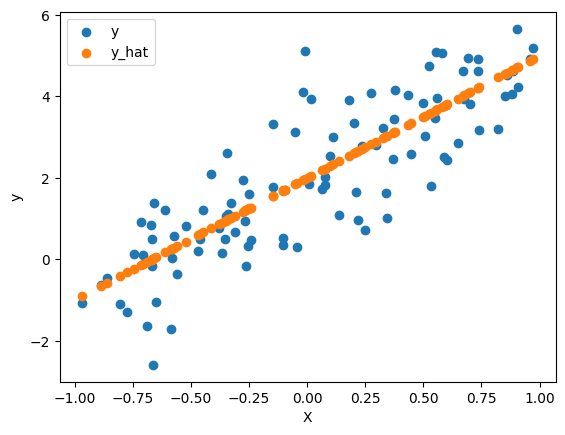

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

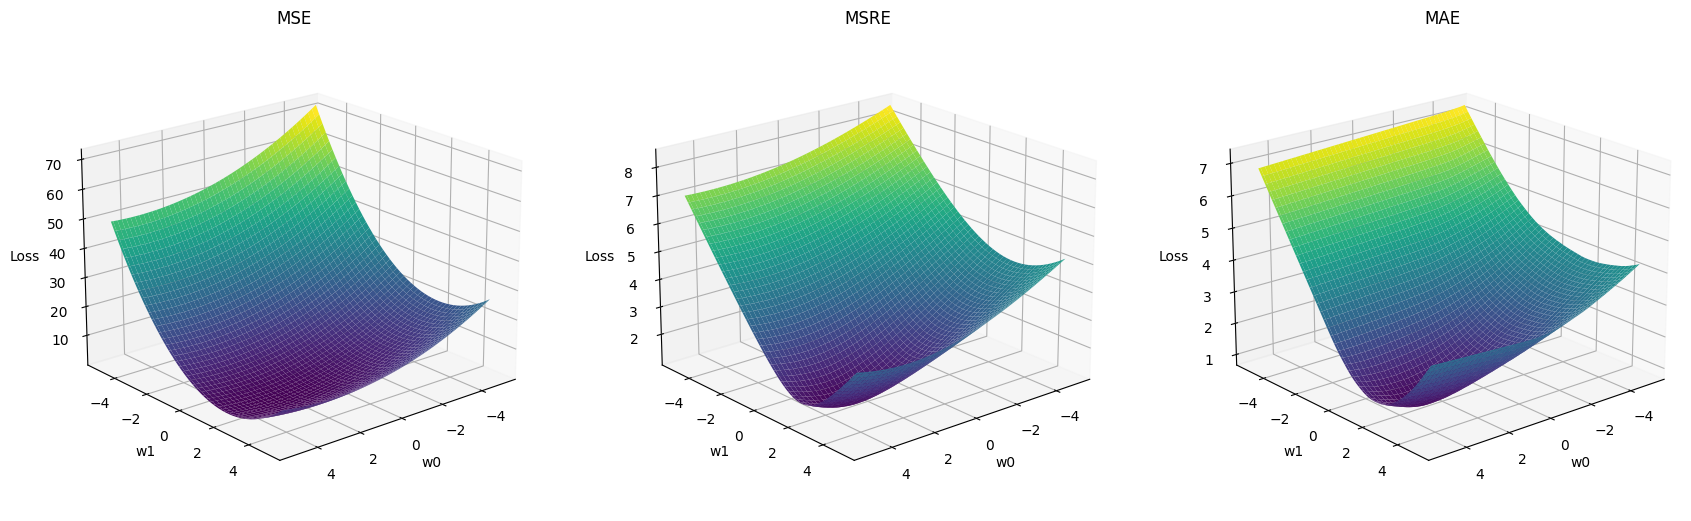

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [9]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
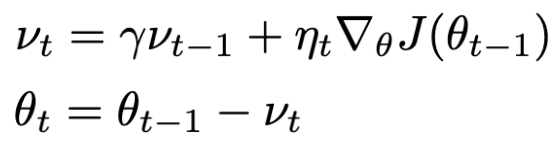

In [20]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.v[i] = self.gamma * self.v[i] + self.lr * p.grad

                p -= self.v[i]

#### AdaDelta
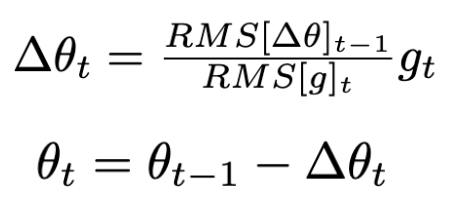

In [45]:
class AdaDelta(Optimizer):
    def __init__(self, params, eta=1e-8, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma
        
        self.E_g2 = [torch.zeros_like(p) for p in self.params]
        self.E_delta2 = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                g = p.grad

                self.E_g2[i] = self.gamma * self.E_g2[i] + (1 - self.gamma) * g**2

                RMS_delta = torch.sqrt(self.E_delta2[i] + self.eta)
                RMS_g = torch.sqrt(self.E_g2[i] + self.eta)
                delta = (RMS_delta / RMS_g) * g

                p -= delta

                self.E_delta2[i] = self.gamma * self.E_delta2[i] + (1 - self.gamma) * delta**2

#### Adam
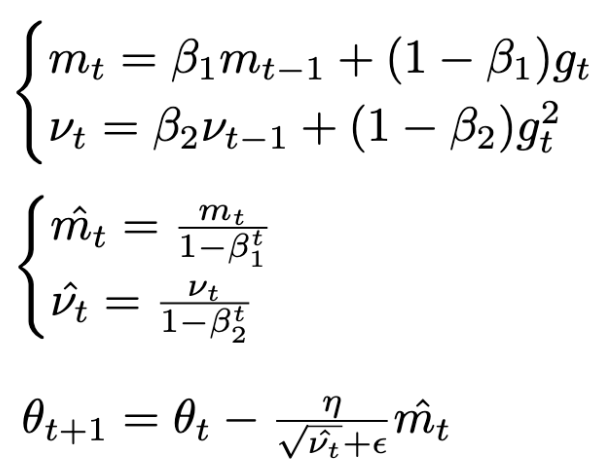

In [40]:
class Adam(Optimizer):
    def __init__(self, params, b1=0.9, b2=0.999, epsilon=1e-8, eta=1e-3):
        super().__init__(params)
        self.b1 = b1
        self.b2 = b2
        self.epsilon = epsilon
        self.eta = eta

        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                g = p.grad

                self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * g
                self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * g**2

                m_hat = self.m[i] / (1 - self.b1**self.t)
                v_hat = self.v[i] / (1 - self.b2**self.t)

                p -= self.eta * m_hat / (torch.sqrt(v_hat) + self.epsilon)

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [22]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), Momentum, {'gamma': 1e-8}, start_point=[-4, -4], num_iter=100)

In [53]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 0.1}],
        ['Momentum', Momentum,  {'lr': 0.01, 'gamma': 0.9}],
        ['AdaGrad', AdaGrad, {'epsilon': 1e-8, 'eta': 1.0}], 
        ['AdaDelta', AdaDelta, {'eta': 1e-2, 'gamma': 0.95}], 
        ('Adam', Adam, {'b1': 0.9, 'b2': 0.999, 'eta': 0.5}),
     ],
    start_point=[-4, -4],
    num_iter=100
)

/raid/alebedev/myenvtr/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:140: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/raid/alebedev/myenvtr/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [54]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2024-10-16 19:07:09--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-10-16 19:07:10--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [           <=>      ]  33.20M  1.71MB/s    in 9.3s    

2024-10-16 19:07:20 (3.56 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [55]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [56]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Сверточные слои
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Dropout для регуляризации
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.dropout1(x)
        
        x = x.view(-1, 64 * 7 * 7)
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [76]:
network = Net()
optimizer = Adam(network.parameters())

Запустите обучение, постройте график лоссов от эпохи:

In [77]:
losses = []

network.train()
for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()


    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        1, batch_idx * len(data), len(train_loader.dataset),
         100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.item())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286678
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.469127
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.312336
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.176633
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.173429
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.219104
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.280705
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.127172
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.235214
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.341771
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.262569
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.152459
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.031947
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.017965
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.260522
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.049748
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.115898
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.114246
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.012039


### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

In [69]:
losses_SGD = losses

In [72]:
losses_Momentum = losses

In [75]:
losses_AdaGrad = losses

In [66]:
losses_AdaDelta = losses

In [78]:
losses_Adam = losses

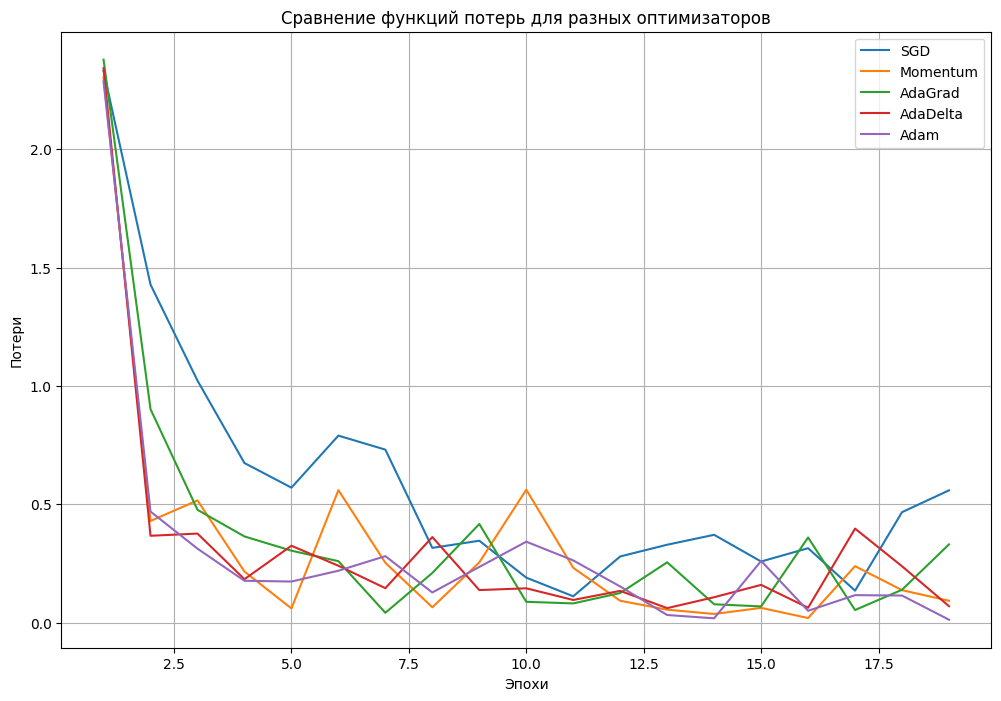

In [80]:
import matplotlib.pyplot as plt

# Предполагаем, что все массивы losses имеют одинаковую длину
epochs = range(1, len(losses_SGD) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, losses_SGD, label='SGD')
plt.plot(epochs, losses_Momentum, label='Momentum')
plt.plot(epochs, losses_AdaGrad, label='AdaGrad')
plt.plot(epochs, losses_AdaDelta, label='AdaDelta')
plt.plot(epochs, losses_Adam, label='Adam')

plt.title('Сравнение функций потерь для разных оптимизаторов')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: